# Project D - Severstal Steel Defect Detection Kaggle Competition 
## Semantic Segmentation of steel defects
### Authors: Utkrisht Rajkumar, Subrato Chakravorty, Chi-Hsin Lo

This is the demo file used to generate our figures and test our best working model.

In [1]:
import os
import json
import gc
import cv2
import keras
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import sys
from data_gen import DataGenerator

Using TensorFlow backend.


## Load Model

In [2]:
from utils import dice_coef, bce_dice, post_process
from model import relu6

In [3]:
model_path = './models/unet.h5'
cb={'bce_dice': bce_dice, 'dice_coef': dice_coef, 'relu6':relu6, 'tf':tf}
unet = load_model(model_path, custom_objects=cb)

model_path = './models/unet_res.h5'
unet_res = load_model(model_path, custom_objects=cb)

model_path = './models/unet_invres.h5'
unet_invres = load_model(model_path, custom_objects=cb)
model_path = './models/deeplabv1.h5'
deeplab = load_model(model_path, custom_objects=cb)

In [4]:
models = [unet, unet_res, unet_invres, deeplab]

## Qualitative results on validation images

In [5]:
BATCH_SIZE = 3
train_df = pd.read_csv('../input/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
val_idx = np.load('val_idx.npy')
val_generator = DataGenerator(val_idx, df=mask_count_df, target_df=train_df, batch_size=BATCH_SIZE, n_classes=4)

image idx:  30


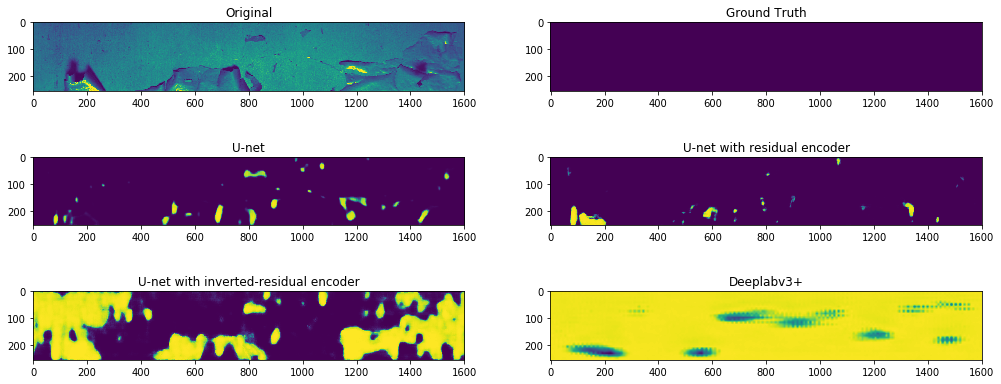

image idx:  20


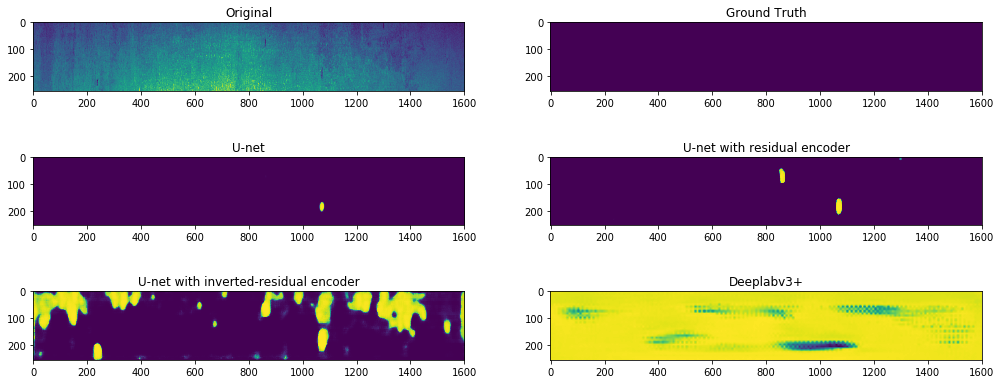

image idx:  40


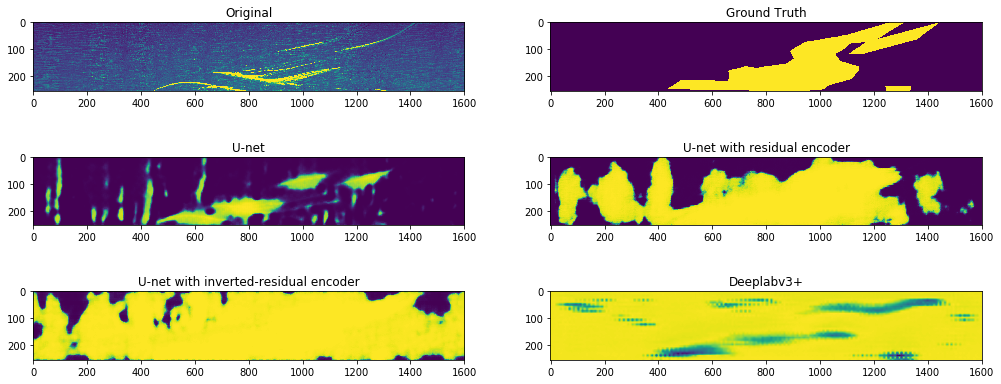

image idx:  70


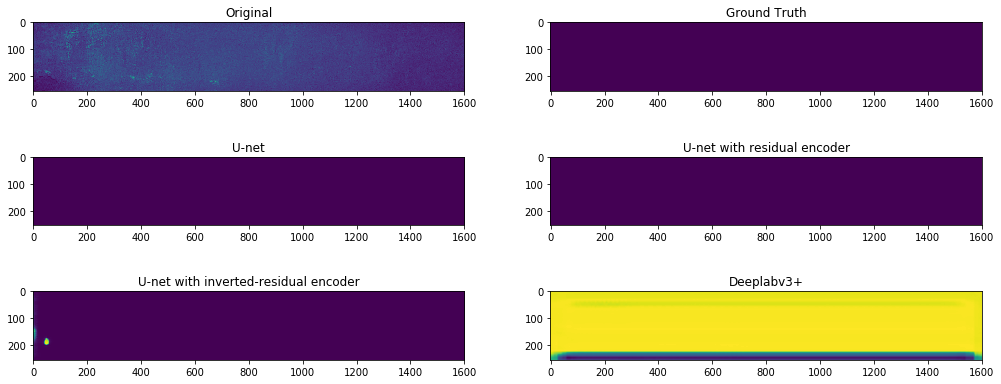

In [17]:
for idx in [30, 20, 40, 70]:
    print('image idx: ', idx)
    fig, ax = plt.subplots(3,2, figsize=(17,7))
    test = val_generator.__getitem__(idx)
    ax[0,0].imshow(np.squeeze(test[0][0]))
    ax[0,1].imshow(np.sum(test[1][0], axis=-1))
    preds = [model.predict(np.expand_dims(test[0][0], axis=0)) for model in models]
    ax[1,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[1,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[2,0].imshow(np.squeeze(preds[2])[...,2])
    ax[2,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('Original'); ax[0,1].set_title('Ground Truth'); ax[1,0].set_title('U-net');ax[1,1].set_title('U-net with residual encoder')
    ax[2,0].set_title('U-net with inverted-residual encoder'); ax[2,1].set_title('Deeplabv3+')
    plt.show()

We suspect that the dataset itself contains noisy labels. For instance, consider the examples above. For image id 30, the original image quite certainly looks as though it contains defects and the network has detected these portions as defects, particularly the U-Net with inverted residual encouder. However, the ground truth indicates that there is no defect at all. 

For image id 20, once again, the U-net and U-net with residual encoder picked up two anaomolies in the original image that seem to be defects but the ground truth has not detected them. But visually, it seems very much like a defect as is consistent with other examples that have marked such visual patterns as defects.

Image id 40 is a clear example of a case where the simplest model did the best. U-Net clearly detects the flaws far better than the other models.

Image id 70 is an example where there doesn't seem to be any flaws in the ground truth and the models also agreed. 

In all these cases, deeplab has a very rough and *inverse* prediction of the defects. For instance in image id 70, the predictions are smooth and in image id 40, the probabilities are polarized in *roughly* the same region as the defects. Noentheless, overall it is clear that DeepLab has done a poor job learning the data. We hypothesize a number of different reasons for why is this is the case in our report. 

## Qualitative results on test images

In [25]:
sample_path = '../input/sample_submission.csv'
sub_df = pd.read_csv(sample_path)
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
b_id = list(range(0, min(test_imgs.shape[0], i + 100)))
test_generator = DataGenerator(b_id, df=test_imgs, shuffle=False,mode='predict',base_path='../input/test_images',
        target_df=sub_df, batch_size=1, n_classes=4)

image idx:  30


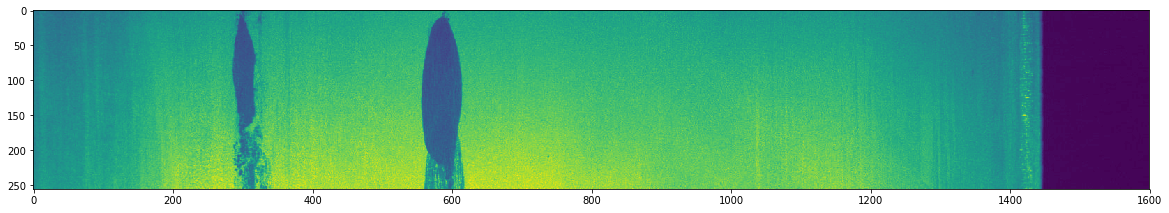

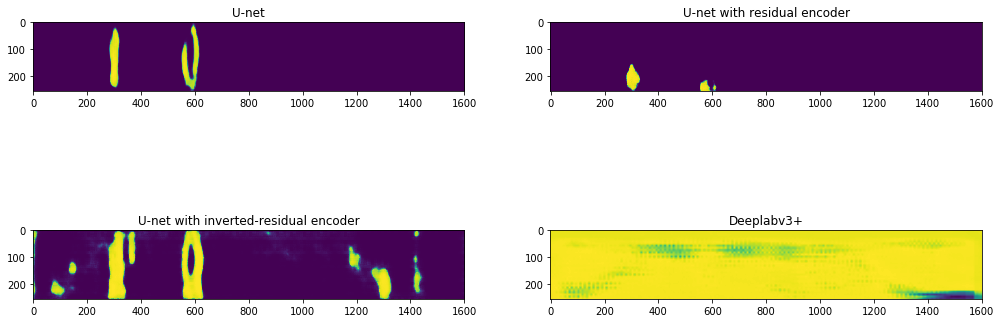

image idx:  20


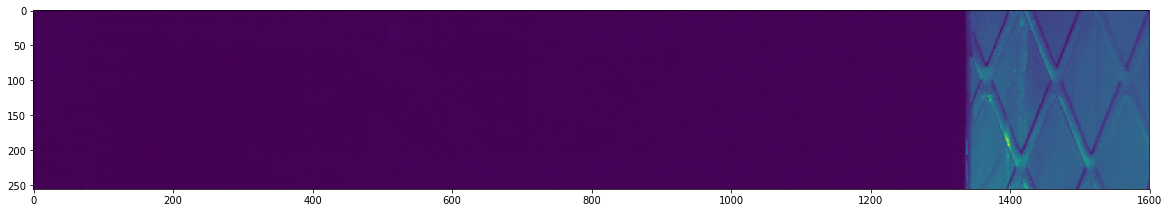

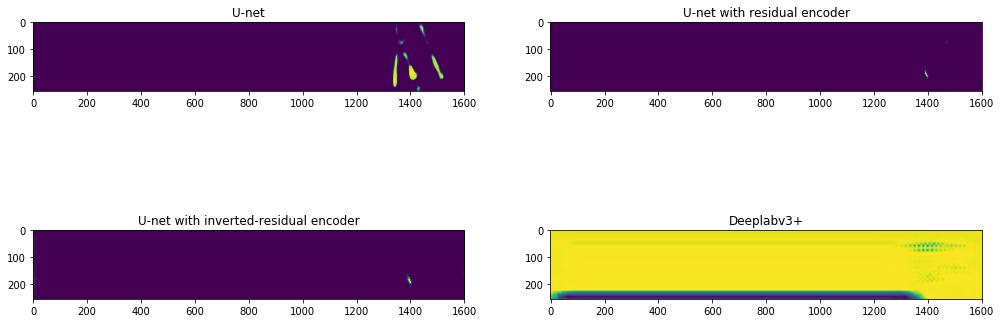

image idx:  40


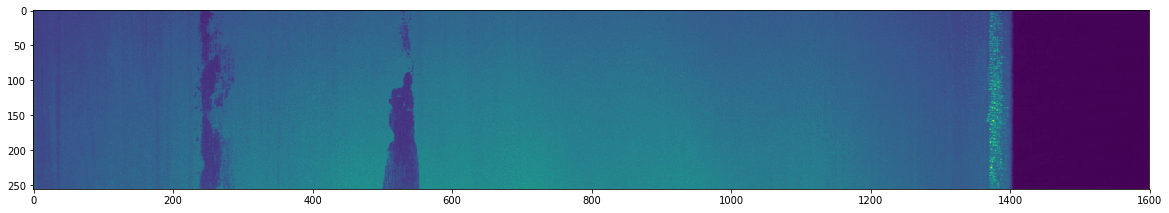

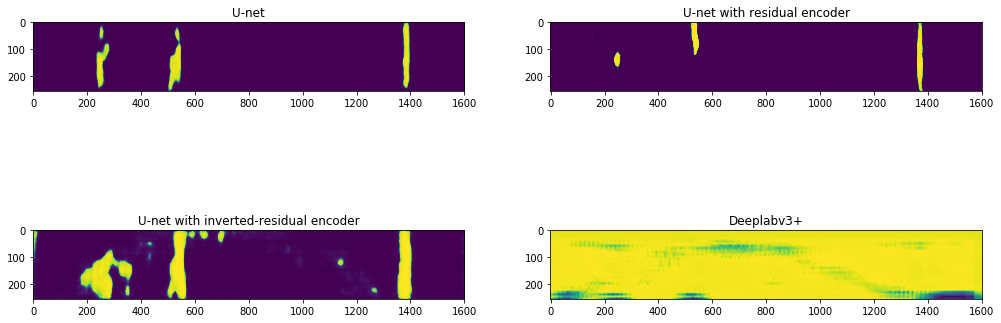

image idx:  70


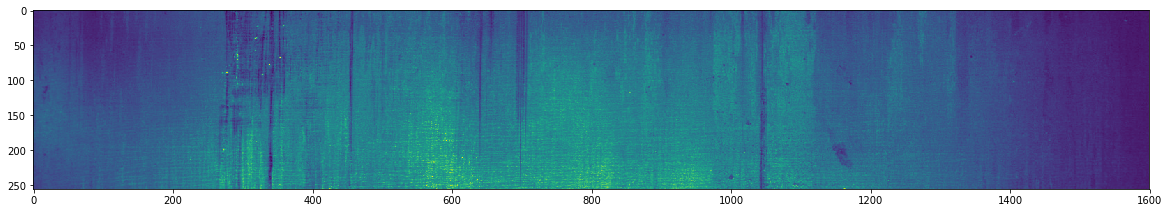

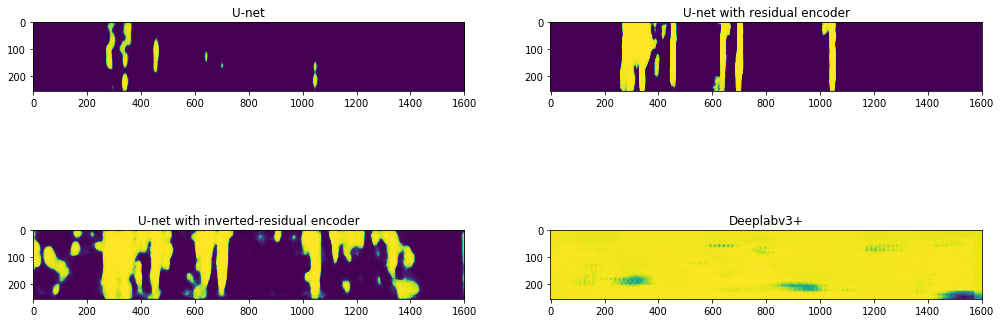

In [38]:
for idx in [30, 20, 40, 70]:
    print('image idx: ', idx)
    test = test_generator.__getitem__(idx)
    plt.figure(figsize=(20,10)); plt.imshow(np.squeeze(test[0])); plt.show()
    fig, ax = plt.subplots(2,2, figsize=(17,7))
    preds = [model.predict(np.expand_dims(test[0], axis=0)) for model in models]
    ax[0,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[0,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[1,0].imshow(np.squeeze(preds[2])[...,2])
    ax[1,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('U-net');ax[0,1].set_title('U-net with residual encoder')
    ax[1,0].set_title('U-net with inverted-residual encoder'); ax[1,1].set_title('Deeplabv3+')
    plt.show()

In image id 30, the best model seems to be U-net, but in image id 20, the u-net seems to predict defects in an image where there seem to be none. In image id 40, the best prediction would probably be an ensemble between two u-net and u-net with residual encoder, and lastly in image 70, u-net with residual encoder seems to work the best. 

Although there exist no ground truth for us to verify this quanitatively, our experience with working with the data and seeing hundreds of such images their corresponding ground truths helps us make this claim.

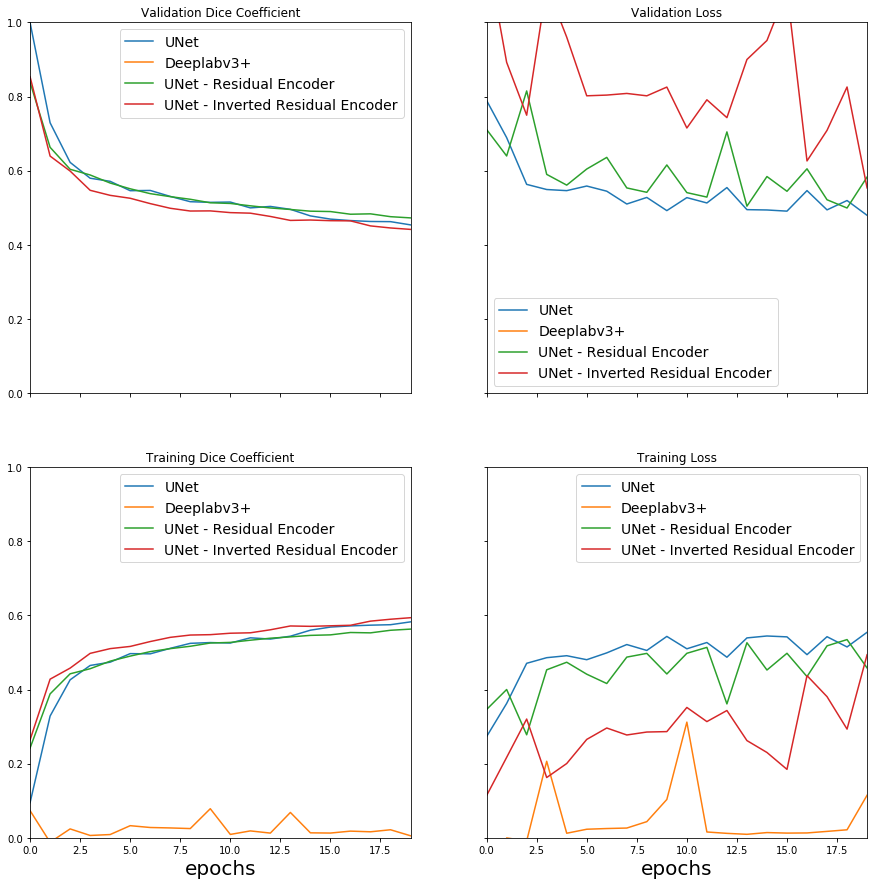

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

files = ['unet_history.csv', 'deeplab_history.csv', 'unet_res_history.csv', 'unet_invres_history.csv']
titles = ['UNet', 'Deeplabv3+', 'UNet - Residual Encoder', 'UNet - Inverted Residual Encoder']
df = pd.DataFrame()

# Plot parameters
params = ['loss','val_loss','dice_coef', 'val_dice_coef']

# Create a dataframe with all the parameters for all models
for i, file in enumerate(files):
    filepath = './history/'+file
    history_df = pd.read_csv(filepath)
    title = titles[i]
    df[title+'_loss'] = history_df['loss']
    df[title+'_val_loss'] = history_df['val_loss']
    df[title+'_dice_coef'] = history_df['dice_coef']
    df[title+'_val_dice_coef'] = history_df['val_dice_coef']

fig, ax = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
ax[1,1].set_xlabel("epochs", fontsize=20); ax[1,0].set_xlabel("epochs", fontsize=20);
plot_list = [title+'_'+params[0] for title in titles]
df[plot_list].plot(title="Validation Dice Coefficient", ax=ax[0,0]); ax[0,0].legend(titles, fontsize=14)
plot_list = [title+'_'+params[1] for title in titles]
df[plot_list].plot(title="Validation Loss", ax=ax[0,1], ylim=[0,1]); ax[0,1].legend(titles, fontsize=14)
plot_list = [title+'_'+params[2] for title in titles]
df[plot_list].plot(title="Training Dice Coefficient", ax=ax[1,0]); ax[1,0].legend(titles, fontsize=14)
plot_list = [title+'_'+params[3] for title in titles]
df[plot_list].plot(title="Training Loss", ax=ax[1,1]); ax[1,1].legend(titles, fontsize=14)

Clearly we can see that U-net and U-net with residual encoder seem to perform the best across all four graphs. Deeplab surely performs the worst on all 4 quantifications.